In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller

#### IMPORT DATA AND ESTABLISH START AND END DATES ####

In [2]:
# Create the foundational dataset
df = pd.read_csv('grocery_dataset_eda.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[(df['date'] >= '2006-01-01') & (df['date'] <= '2025-01-01')]
df = df.reset_index().set_index('date').drop(columns = 'index')

In [3]:
for col in df.columns:
    print(col)

US Grocery Sales
US Food Service and Drinking Places
CPI (Food at Home)
Real Disposable Income
Unemployment Rate
Initial Jobless Claims
Continued Jobless Claims
GDP
Personal Savings
Consumer Debt % DI
Credit Card Delinquency
Mortgage Delinquency
Oil Prices
Avg Home Price
Consumer Sentiment
PPI Farm Products
PPI Final Food
PPI Food and Feed
PPI Finished Consumer Goods
PPI Food Manufacture
PPI Grocery
Retail Wages
us_grocery_units
Real Disposable Income adj
US Grocery Sales_lag1
covid1
covid2
US Grocery Sales_diff
US Food Service and Drinking Places_diff
CPI (Food at Home)_diff
Real Disposable Income_diff
Unemployment Rate_diff
Initial Jobless Claims_diff
Continued Jobless Claims_diff
GDP_diff
Personal Savings_diff
Consumer Debt % DI_diff
Credit Card Delinquency_diff
Mortgage Delinquency_diff
Oil Prices_diff
Avg Home Price_diff
Consumer Sentiment_diff
PPI Farm Products_diff
PPI Final Food_diff
PPI Food and Feed_diff
PPI Finished Consumer Goods_diff
PPI Food Manufacture_diff
PPI Grocery_d

#### RENAME COLUMNS FOR THE MODEL ####

In [4]:
# Rename variables
df = df.rename(columns={
    "CPI (Food at Home)": 'cpi_fah',
    "CPI (Food at Home)_yoy": 'cpi_fah_yoy',
    "CPI (Food at Home)_yoy_lag1": 'cpi_fah_yoy_lag1',
    "PPI Food Manufacture_yoy": 'ppi_mfg_yoy',
    "PPI Food Manufacture_yoy_lag1": 'ppi_mfg_yoy_lag1',
    "PPI Food Manufacture_yoy_lag2": 'ppi_mfg_yoy_lag2',
    "PPI Food Manufacture_yoy_lag3": 'ppi_mfg_yoy_lag3',
    "PPI Food Manufacture_yoy_lag4": 'ppi_mfg_yoy_lag4',
    "PPI Food Manufacture_yoy_lag5": 'ppi_mfg_yoy_lag5',
    "PPI Grocery_yoy": 'ppi_grocery_yoy',
    "US Grocery Units_yoy": 'us_grocery_units_yoy',
    "PPI Farm Products_yoy": 'ppi_farm_products_yoy',
    "PPI Farm Products_yoy_lag1": 'ppi_farm_products_yoy_lag1',
    "PPI Farm Products_yoy_lag2": 'ppi_farm_products_yoy_lag2',
    "PPI Farm Products_yoy_lag3": 'ppi_farm_products_yoy_lag3',
    "PPI Farm Products_yoy_lag4": 'ppi_farm_products_yoy_lag4',
    "PPI Farm Products_yoy_lag5": 'ppi_farm_products_yoy_lag5',
    "PPI Farm Products_yoy_lag6": 'ppi_farm_products_yoy_lag6',
    "PPI Farm Products_yoy_lag7": 'ppi_farm_products_yoy_lag7',
    "Oil Prices_yoy": 'oil_prices_yoy',
    "Oil Prices_yoy_lag1": 'oil_prices_yoy_lag1',
    "Oil Prices_yoy_lag2": 'oil_prices_yoy_lag2',
    "Oil Prices_yoy_lag3": 'oil_prices_yoy_lag3',
    "Oil Prices_yoy_lag4": 'oil_prices_yoy_lag4',
    "Oil Prices_yoy_lag5": 'oil_prices_yoy_lag5',
    "Oil Prices_yoy_lag6": 'oil_prices_yoy_lag6',
    "Oil Prices_yoy_lag7": 'oil_prices_yoy_lag7',
    "Oil Prices_yoy_lag8": 'oil_prices_yoy_lag8',
    "Oil Prices_yoy_lag9": 'oil_prices_yoy_lag9'
    })

#### CHECK FOR MISSING VALUES ####

In [5]:
# Nothing kills a regression faster than missing data
vars = ['cpi_fah', 'cpi_fah_yoy', 'cpi_fah_yoy_lag1', 'ppi_mfg_yoy_lag5', 'ppi_mfg_yoy', 'ppi_grocery_yoy', 'us_grocery_units_yoy', 'oil_prices_yoy_lag1']

# Count total missing values per column
missing_counts = df[vars].isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

#### PPI MFG MODEL VS OIL PRICES ####

In [6]:
# Define independent (X) and dependent (y) variables
X = df[['oil_prices_yoy_lag1']]
y = df['ppi_farm_products_yoy']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
ppi_model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(ppi_model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['ppi_farm_products_yoy_pred'] = ppi_model.fittedvalues
df['ppi_farm_products_yoy_resid'] = ppi_model.resid

                              OLS Regression Results                             
Dep. Variable:     ppi_farm_products_yoy   R-squared:                       0.407
Model:                               OLS   Adj. R-squared:                  0.405
Method:                    Least Squares   F-statistic:                     156.1
Date:                   Sun, 30 Mar 2025   Prob (F-statistic):           1.32e-27
Time:                           15:41:08   Log-Likelihood:                -873.19
No. Observations:                    229   AIC:                             1750.
Df Residuals:                        227   BIC:                             1757.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

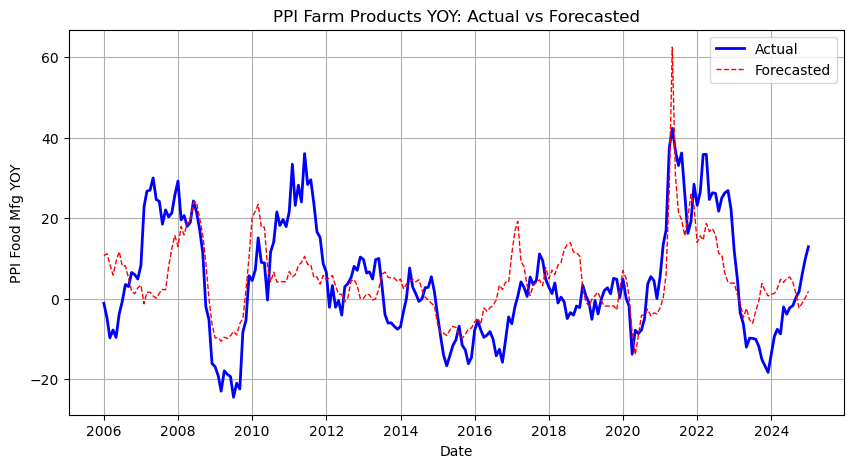

In [7]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='ppi_farm_products_yoy', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='ppi_farm_products_yoy_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('PPI Food Mfg YOY')
plt.title('PPI Farm Products YOY: Actual vs Forecasted')
plt.legend()
plt.grid(True)

plt.show()

#### CPI FAH MODEL VS PPI MEASURES ####

In [8]:
#df = df[(df.index >= '2007-01-01') & (df.index <= '2025-01-01')]

# Define independent (X) and dependent (y) variables
X = df[['ppi_mfg_yoy_lag5', 'ppi_grocery_yoy', 'us_grocery_units_yoy']]
y = df['cpi_fah_yoy']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
cpi_model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(cpi_model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['cpi_fah_yoy_pred'] = cpi_model.fittedvalues
df['cpi_fah_yoy_resid'] = cpi_model.resid

                            OLS Regression Results                            
Dep. Variable:            cpi_fah_yoy   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     329.5
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           5.02e-82
Time:                        15:41:09   Log-Likelihood:                -398.11
No. Observations:                 229   AIC:                             804.2
Df Residuals:                     225   BIC:                             818.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4173 

#### VISUALS AND DIAGNOSTICS ####

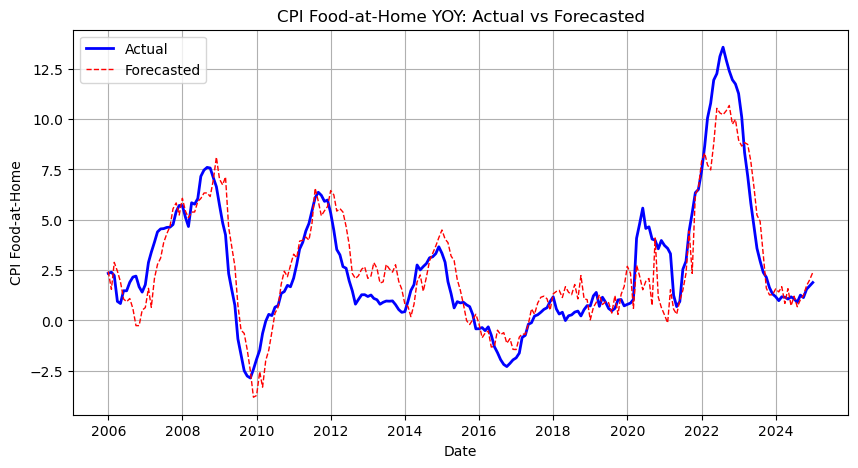

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='cpi_fah_yoy', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='cpi_fah_yoy_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('CPI Food-at-Home')
plt.title('CPI Food-at-Home YOY: Actual vs Forecasted')
plt.legend()
plt.grid(True)

plt.show()

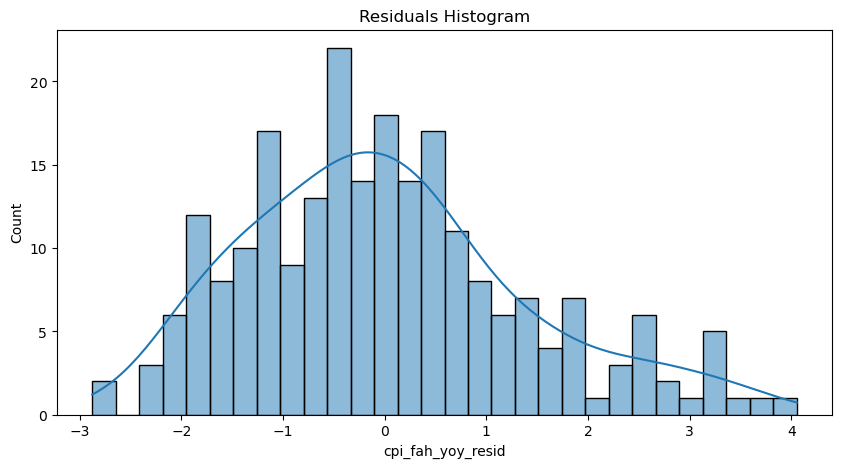

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df["cpi_fah_yoy_resid"], bins=30, kde=True)
plt.title('Residuals Histogram')
plt.show()

<Figure size 1000x500 with 0 Axes>

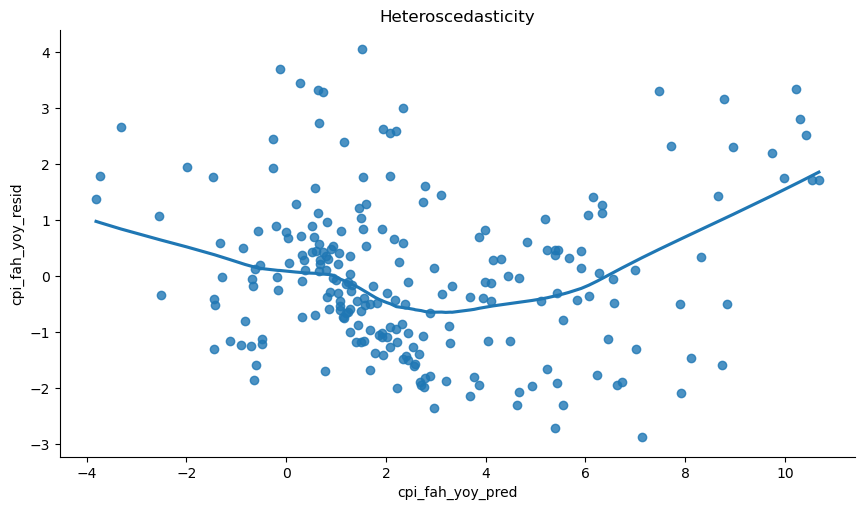

In [11]:
plt.figure(figsize=(10, 5))
sns.lmplot(x="cpi_fah_yoy_pred", y="cpi_fah_yoy_resid", data=df, lowess=True, aspect=1.75, height=5)
plt.title('Heteroscedasticity')
plt.show()

In [12]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,2.734556
1,ppi_mfg_yoy_lag5,1.792641
2,ppi_grocery_yoy,1.649543
3,us_grocery_units_yoy,1.380797


#### GET SE MEAN AND CONFIDENCE INTERVALS ####

In [13]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = cpi_model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store confidence intervals
df['cpi_fah_yoy_se_mean'] = pred_summary['mean_se']  # SE of the mean
df['cpi_fah_yoy_se_lower'] = pred_summary['mean_ci_lower']  # SE of the mean
df['cpi_fah_yoy_se_upper'] = pred_summary['mean_ci_upper']  # SE of the mean
df['lower_bound'] = pred_summary['obs_ci_lower']  # SE of the mean
df['upper_bound'] = pred_summary['obs_ci_upper']  # SE of the mean

# ✅ Compute SE of the estimate (obs_se) using the upper and lower columns 
df['cpi_fah_yoy_se_obs'] = (df['upper_bound'] - df['lower_bound']) / (2 * 1.96)  # 95% CI

# # Show first few rows
df[['cpi_fah_yoy_se_mean', 'cpi_fah_yoy_se_mean', 'cpi_fah_yoy_se_obs', 'cpi_fah_yoy_se_lower', 'cpi_fah_yoy_se_upper', 
    'lower_bound', 'upper_bound']].head()

,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_obs,cpi_fah_yoy_se_lower,cpi_fah_yoy_se_upper,lower_bound,upper_bound
date,,,,,,,
2006-01-01,0.157554,0.157554,1.405133,2.127154,2.748096,-0.316436,5.191686
2006-02-01,0.103500,0.103500,1.400049,1.340267,1.748173,-1.199875,4.288315
2006-03-01,0.130405,0.130405,1.402319,2.628909,3.142852,0.137336,5.634425
2006-04-01,0.111631,0.111631,1.400680,2.230172,2.670124,-0.295184,5.195481
2006-05-01,0.115516,0.115516,1.400998,1.698155,2.153417,-0.820171,4.671742


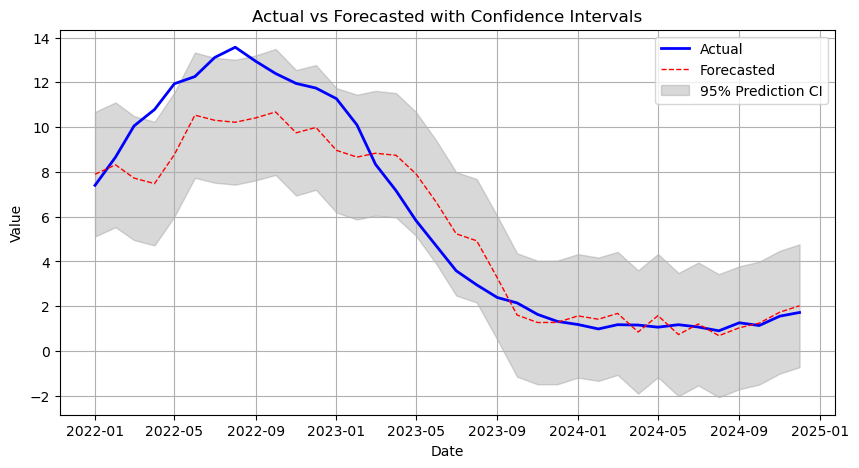

In [14]:
#Define the start and end date for filtering
start_date = '2022-01-01'
end_date = '2024-12-31'

#Filter the DataFrame to only include the desired months
df_subset = df.loc[start_date:end_date]
df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_subset, x=df_subset.index, y=df_subset['cpi_fah_yoy'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_subset, x=df_subset.index, y='cpi_fah_yoy_pred', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_subset.index, df_subset['lower_bound'], df_subset['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


#### VALIDATE THE MODEL ####

In [15]:
# Make sure the index is datetime and sorted
df_validate = df.sort_index()
df_validate.index = pd.to_datetime(df_validate.index)  # If it's not already datetime

results = []

# Define unique months in the index
all_months = df_validate.index.to_period('M').unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 6

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]

    train_df = df_validate[df_validate.index.to_period('M').isin(train_months)]
    test_df = df_validate[df_validate.index.to_period('M').isin(test_months)]
    
    # ✅ Define train and test features and targets
    X_train = train_df[['ppi_mfg_yoy_lag5', 'ppi_grocery_yoy', 'us_grocery_units_yoy']]
    y_train = train_df["cpi_fah_yoy"]

    X_test = test_df[['ppi_mfg_yoy_lag5', 'ppi_grocery_yoy', 'us_grocery_units_yoy']]
    y_test = test_df["cpi_fah_yoy"]
    
    # ✅ Fit model and predict
    cpi_validate = LinearRegression()
    cpi_validate.fit(X_train, y_train)
    forecast = cpi_validate.predict(X_test)

    mae = mean_absolute_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0].strftime('%Y-%m'),
        'test_end': test_months[-1].strftime('%Y-%m'),
        'MAE': mae,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)


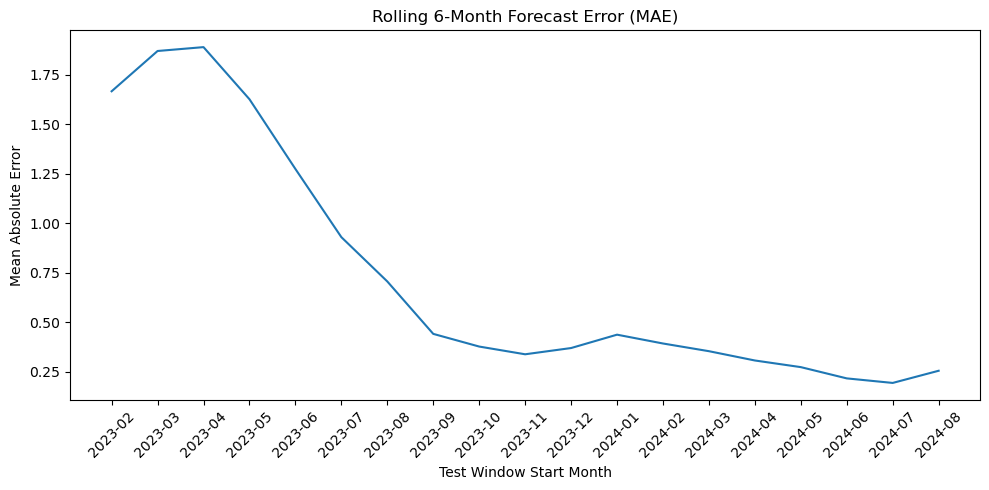

In [16]:
# Drop rows where MAE is NaN
plot_data = rolling_results_df.dropna(subset=['MAE'])

# Now plot
plt.figure(figsize=(10, 5))
plt.plot(plot_data['test_start'], plot_data['MAE'])
plt.xticks(rotation=45)
plt.title('Rolling 6-Month Forecast Error (MAE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.show()

#### FORWARD FORECAST - ESTIMATE THE INPUTS AND BUILD THE FILE ####

In [17]:
#Independent forward forecast estimates

ppi_grocery_yoy_dic = {pd.Timestamp('2025-02-01'): 1.8, pd.Timestamp('2025-03-01'): 2.0, pd.Timestamp('2025-04-01'): 2.2, pd.Timestamp('2025-05-01'): 2.4,
                pd.Timestamp('2025-06-01'): 2.6, pd.Timestamp('2025-07-01'): 2.8}

ppi_mfg_yoy_dic = {pd.Timestamp('2025-02-01'): 2.1, pd.Timestamp('2025-03-01'): 3.7, pd.Timestamp('2025-04-01'): 3.3, pd.Timestamp('2025-05-01'): 4.4,
                pd.Timestamp('2025-06-01'): 5.2, pd.Timestamp('2025-07-01'): 5.25}

us_grocery_units_yoy_dic = {pd.Timestamp('2025-02-01'): 2.0, pd.Timestamp('2025-03-01'): 1.8, pd.Timestamp('2025-04-01'): 1.6, pd.Timestamp('2025-05-01'): 1.4,
                pd.Timestamp('2025-06-01'): 1.2, pd.Timestamp('2025-07-01'): 1.0}

In [18]:
df['cpi_fah_yoy_se_obs']

date
2006-01-01    1.405133
2006-02-01    1.400049
2006-03-01    1.402319
2006-04-01    1.400680
2006-05-01    1.400998
                ...   
2024-09-01    1.401549
2024-10-01    1.400276
2024-11-01    1.400601
2024-12-01    1.399920
2025-01-01    1.400123
Name: cpi_fah_yoy_se_obs, Length: 229, dtype: float64

#### BUILD THE FORWARD FILE AND PREP FOR CONCAT ####

In [19]:
# Define the forward forecast period and build the file

# Build the df based on the date range.  The months become the index
forecast_months = pd.date_range("2025-02-01", "2025-07-01", freq="MS")
forward_df = pd.DataFrame(index=forecast_months)

# Fill in known inputs by defining the previous year values so we can estimate the YOY values for the forecast
# THis loop grabs last years value and then applies the growth rate to calculate the future input value
# date and prev_year are the outputs that are inserted into the formulas below
for date in forecast_months:
    prev_year = date - pd.DateOffset(years=1)  
    
    forward_df.loc[date, "ppi_grocery_yoy"] = ppi_grocery_yoy_dic[date]
    forward_df.loc[date, "ppi_mfg_yoy_lag5"] = ppi_mfg_yoy_dic[date]
    forward_df.loc[date, "us_grocery_units_yoy"] = us_grocery_units_yoy_dic[date]


# # Initialize lag variable
# last_known_value = df.loc["2025-01-01", "cpi_fah"]
# forward_df["us_grocery_sales_lag1"] = np.nan
# forward_df.loc[forecast_months[0], "us_grocery_sales_lag1"] = last_known_value

# Add empty columns for forecast and intervals
forward_df["cpi_fah_yoy"] = np.nan
forward_df["cpi_fah_yoy_pred"] = np.nan

# Pull the 6 months of SE values from one year ago
se_obs_values = df['cpi_fah_yoy_se_obs'].iloc[-12:-6].copy()  

# Shift the index forward to 2025
se_obs_values.index = se_obs_values.index + pd.DateOffset(years=1)

# Assign these shifted SE values into forward_df
forward_df.loc[se_obs_values.index, 'cpi_fah_yoy_se_obs'] = se_obs_values

forward_df

,ppi_grocery_yoy,ppi_mfg_yoy_lag5,us_grocery_units_yoy,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs
2025-02-01,1.8,2.10,2.0,NaN,NaN,1.405415
2025-03-01,2.0,3.70,1.8,NaN,NaN,1.402819
2025-04-01,2.2,3.30,1.6,NaN,NaN,1.404428
2025-05-01,2.4,4.40,1.4,NaN,NaN,1.403834
2025-06-01,2.6,5.20,1.2,NaN,NaN,1.403822
2025-07-01,2.8,5.25,1.0,NaN,NaN,1.400240


In [20]:
for col in forward_df.columns:
    print(col)

ppi_grocery_yoy
ppi_mfg_yoy_lag5
us_grocery_units_yoy
cpi_fah_yoy
cpi_fah_yoy_pred
cpi_fah_yoy_se_obs


#### GET THE COEF FOR THE FORWARD FCST ####

In [21]:
cpi_fah_yoy_coef = {name: value for name, value in cpi_model.params.items()}
cpi_fah_yoy_coef

{'const': 0.4173334719229085,
 'ppi_mfg_yoy_lag5': 0.41965498347373065,
 'ppi_grocery_yoy': 0.2320453408536442,
 'us_grocery_units_yoy': -0.07209586742836056}

In [22]:
const = cpi_fah_yoy_coef['const']
ppi_mfg_yoy_lag5 = cpi_fah_yoy_coef['ppi_mfg_yoy_lag5']
ppi_grocery_yoy = cpi_fah_yoy_coef['ppi_grocery_yoy']
us_grocery_units_yoy = cpi_fah_yoy_coef['us_grocery_units_yoy']

#### MAKE THE FORWARD FCST ####

In [23]:
# Initialize values before the loop
forecasted_cpi_fah = []
lower_ci = []
upper_ci = []

# Loop through each row in forward_df
for i, row in forward_df.iterrows():
    y_hat = (
        const +
        ppi_mfg_yoy_lag5 * row['ppi_mfg_yoy_lag5'] +
        ppi_grocery_yoy * row["ppi_grocery_yoy"] +
        us_grocery_units_yoy * row["us_grocery_units_yoy"]
    )

    forecasted_cpi_fah.append(round(y_hat, 2))

    # Calculate and store confidence intervals
    lower_ci.append(y_hat - 1.96 * row["cpi_fah_yoy_se_obs"])
    upper_ci.append(y_hat + 1.96 * row["cpi_fah_yoy_se_obs"])

# Assign all lists to the DataFrame
forward_df['cpi_fah_yoy_pred'] = forecasted_cpi_fah
forward_df['lower_bound'] = lower_ci
forward_df['upper_bound'] = upper_ci

#### CONCAT THE FORWARD DF AND DF ####

In [24]:
# Stack the df and forward df
df_subset = df[forward_df.columns]
df_subset = pd.concat([df_subset, forward_df], axis=0)
df_subset.tail(12)

,ppi_grocery_yoy,ppi_mfg_yoy_lag5,us_grocery_units_yoy,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs,lower_bound,upper_bound
2024-08-01,0.484107,0.463688,0.586153,0.900476,0.681998,1.402566,-2.067032,3.431028
2024-09-01,0.756637,1.232838,1.031872,1.258809,1.035881,1.401549,-1.711156,3.782917
2024-10-01,1.678139,1.291654,1.474888,1.136562,1.242453,1.400276,-1.502088,3.986995
2024-11-01,1.839778,2.212094,0.580579,1.554147,1.730705,1.400601,-1.014474,4.475883
2024-12-01,2.354873,2.805668,1.698910,1.719773,2.018699,1.399920,-0.725144,4.762542
2025-01-01,5.061854,2.221742,1.865908,1.884939,2.389754,1.400123,-0.354486,5.133994
2025-02-01,1.800000,2.100000,2.000000,NaN,1.570000,1.405415,-1.182514,4.326711
2025-03-01,2.000000,3.700000,1.800000,NaN,2.300000,1.402819,-0.445149,5.053899
2025-04-01,2.200000,3.300000,1.600000,NaN,2.200000,1.404428,-0.555338,4.950020
2025-05-01,2.400000,4.400000,1.400000,NaN,2.720000,1.403834,-0.031725,5.471305


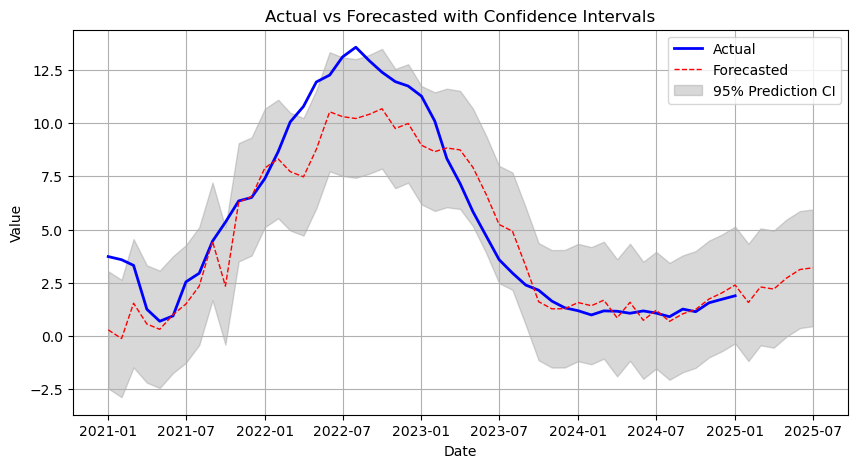

In [25]:
#Define the start and end date for filtering
start_date = '2021-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_chart = df_subset.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['cpi_fah_yoy'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['cpi_fah_yoy_pred'], label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

In [26]:
df_monthly.to_csv('cpi_fah_forecast_month.csv')

NameError: name 'df_monthly' is not defined

In [27]:
df_chart

,ppi_grocery_yoy,ppi_mfg_yoy_lag5,us_grocery_units_yoy,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs,lower_bound,upper_bound
2021-01-01,1.814709,-0.346192,5.711446,3.727552,0.281375,1.405410,-2.473229,3.035979
2021-02-01,0.000000,-0.197824,6.375011,3.581081,-0.125296,1.407879,-2.884738,2.634146
2021-03-01,-1.564657,0.693756,-16.469242,3.313648,1.532765,1.540380,-1.486380,4.551909
2021-04-01,-1.140511,0.885827,-0.454407,1.251080,0.557186,1.407542,-2.201596,3.315968
2021-05-01,-1.813110,0.788177,0.273458,0.687912,0.307657,1.407842,-2.451712,3.067027
2021-06-01,1.196745,1.284585,3.265126,0.939240,0.998713,1.401298,-1.747831,3.745257
2021-07-01,-1.942657,3.832753,1.060342,2.538462,1.498536,1.410564,-1.266169,4.263241
2021-08-01,0.164276,5.373134,5.115136,2.944303,2.341535,1.413227,-0.428389,5.111460
2021-09-01,4.290091,7.932573,4.140903,4.451239,4.443231,1.410990,1.677691,7.208771
2021-10-01,3.329280,3.513638,4.523353,5.342134,2.338278,1.404151,-0.413857,5.090413
